# **Applying Machine Learning to Sentiment Analysis**

In this chapter, we will delve into a subfield of **natural language processing (NLP)**  called **sentiment analysis**  and learn how to use machine learning
algorithms to classify documents based on their sentiment: the attitude of the writer. In particular, we are going to work with a dataset of 50,000 movie reviews from the Internet Movie Database (IMDb) and build a predictor that can distinguish between positive and negative reviews.

-  Cleaning and preparing text data
- Building feature vectors from text documents
- Training a machine learning model to classify positive and negative movie reviews
- Working with large text datasets using out-of-core learning
- Inferring topics from document collections for categorization


### **Preparing the IMDb movie review data for text processing**
Sentiment analysis, sometimes also called **opinion mining**, is a popular subdiscipline of the broader field of NLP; it is concerned with analyzing the sentiment of documents. A popular task
in sentiment analysis is the classification of documents based on the expressed opinions or emotions
of the authors with regard to a particular topic.

The movie review dataset consists of 50,000 polar movie reviews that are labeled as either positive or negative; here, positive means that a movie was rated with more than six stars on IMDb, and negative means that a movie was rated with fewer than five stars on IMDb.


### **Obtaining the movie review dataset**

In [ ]:
"""
import tarfile

with tarfile.open('/content/aclImdb_v1.tar.gz', 'r:gz') as tar:
  tar.extractall()
"""

In [2]:
!pip install pyprind

In [ ]:
import pyprind
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from packaging import version


# change the `basepath` to the directory of the
# unzipped movie dataset
"""
basepath = '/content/aclImdb'

labels = {'pos': 1, 'neg': 0}
# if the progress bar does not show, change stream=sys.stdout to stream=2
pbar = pyprind.ProgBar(50000, stream=sys.stdout)

df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file),
                      'r', encoding='utf-8') as infile:
                txt = infile.read()

            if version.parse(pd.__version__) >= version.parse("1.3.2"):
                x = pd.DataFrame([[txt, labels[l]]], columns=['review', 'sentiment'])
                df = pd.concat([df, x], ignore_index=False)

            else:
                df = df.append([[txt, labels[l]]],
                               ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']
"""

For our own convenience, we will also store the assembled and shuffled movie review dataset as a
CSV file:

In [15]:
import numpy as np
np.random.seed(0)
#df = df.reindex(np.random.permutation(df.index))
#df.to_csv('movie_data.csv', index=False, encoding='utf-8')

 let’s quickly confirm that we have successfully saved the data in the right format by reading in the CSV and printing an excerpt of the first three
examples:

In [16]:
df = pd.read_csv("/content/movie_data.csv", engine="python")
# the following column renaming is necessary on some computers:
#df = df.rename(columns={"0": "review", "1": "sentiment"})
df.head(3)

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1


As a sanity check, before we proceed to the next section, let’s make sure that the DataFrame contains
all 50,000 rows:


In [18]:
# shape of the data
df.shape

(50000, 2)

In [19]:
# columns
df.columns

Index(['review', 'sentiment'], dtype='object')

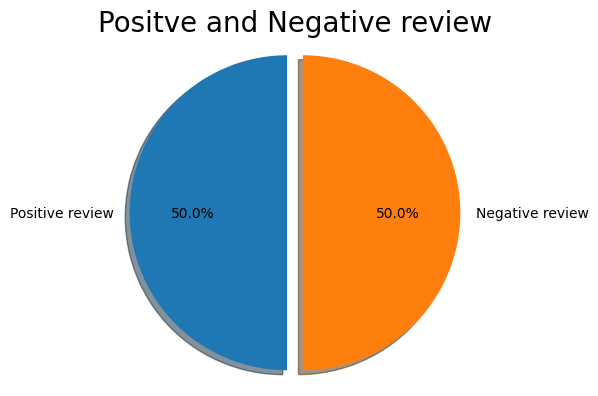

In [20]:
# visualize in a pie chart the bad comment vs good review
labels = 'Positive review', 'Negative review'
sizes = [df.sentiment[df['sentiment']==1].count(), df.sentiment[df['sentiment']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(6.5, 4.5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Positve and Negative review", size = 20)
plt.show()

### **Introducing the bag-of-words model**

In this section, we will introduce the bag-of-words model, which allows
us to represent text as numerical feature vectors. The idea behind bag-of-words is quite simple and
can be summarized as follows:

 1. We create a vocabulary of unique tokens—for example, words—from the entire set of documents.
 2. We construct a feature vector from each document that contains the counts of how often each
word occurs in the particular document.

### **Transforming words into feature vectors**

To construct a bag-of-words model based on the word counts in the respective documents, we can use
the CountVectorizer class implemented in scikit-learn. As you will see in the following code section,
CountVectorizer takes an array of text data, which can be documents or sentences, and constructs
the bag-of-words model for us:


In [22]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

Now let us print the contents of the vocabulary to get a better understanding of the underlying concepts:

In [23]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


As you can see from executing the preceding command, the vocabulary is stored in a Python dictionary
that maps the unique words to integer indices. Next, let’s print the feature vectors that we just created:

In [24]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


### **Assessing word relevancy via term frequency-inverse document  frequency**

**Term frequency-inverse document frequency (tf-idf)**, which can be used to downweight these frequently occurring
words in the feature vectors. The tf-idf can be defined as the product of the term frequency and the inverse document frequency:

Scikit-learn implements yet another transformer, the TfidfTransformer, that takes the raw term frequencies from CountVectorizer as input and transforms them into tf-idfs:

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs))
      .toarray())

[[0.         0.43370786 0.         0.55847784 0.55847784 0.
  0.43370786 0.         0.        ]
 [0.         0.43370786 0.         0.         0.         0.55847784
  0.43370786 0.         0.55847784]
 [0.50238645 0.44507629 0.50238645 0.19103892 0.19103892 0.19103892
  0.29671753 0.25119322 0.19103892]]


### **Cleaning text data**
 let’s display the last 50 characters from the first document in the
reshuffled movie review dataset:

In [26]:
df.loc[3, 'review'][-100:]

"movies are a dime a dozen, but this one stands out. <br /><br />This is one I'd recommend to anyone."

Simplicity, we will now
remove all punctuation marks except for emoticon characters, such as :), since those are certainly
useful for sentiment analysis.

Python’s regular expression (**regex**) library, re, as shown here

In [27]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

But before we talk more about
the splitting of documents into individual terms, words, or tokens, let’s confirm that our preprocessor
function works correctly:

In [28]:
preprocessor(df.loc[3, 'review'][-100:])

'movies are a dime a dozen but this one stands out this is one i d recommend to anyone '

In [29]:
 preprocessor("</a>This :) is :( a test :-) :P!")

'this is a test p :) :( :) :P'

let’s now apply our preprocessor function to all the movie reviews in our DataFrame:

In [30]:
 df['review'] = df['review'].apply(preprocessor)

In [31]:
df.loc[3, 'review'][-100:]

't golf sports movies are a dime a dozen but this one stands out this is one i d recommend to anyone '

### **Processing documents into tokens**

After successfully preparing the movie review dataset, we now need to think about how to split the
text **corpora** into individual elements. One way to tokenize documents is to split them into individual
words by splitting the cleaned documents at their whitespace characters:

In [32]:
def tokenizer(text):
     return text.split()

tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In the context of tokenization, another useful technique is **word stemming**, which is the process of
transforming a word into its root form. It allows us to map related words to the same stem. The original stemming algorithm was developed by Martin F. Porter in 1979 and is hence known as the **Porter  stemmer** algorithm (An algorithm for suffix stripping by Martin F. Porter, Program: Electronic Library
and Information Systems, 14(3): 130–137, 1980). The **Natural Language Toolkit (NLTK, http://www.nltk.org)** for Python implements the Porter stemming algorithm, which we will use in the following
code section. To install the NLTK, you can simply execute conda install nltk or pip install nltk.

In [33]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer_porter(text):
     return [porter.stem(word) for word in text.split()]
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

**Stop words**

are simply those words that are extremely common in all sorts of texts and probably bear no (or only
a little) useful information that can be used to distinguish between different classes of documents.
Examples of stop words are is, and, has, and like. Removing stop words can be useful if we are working
with raw or normalized term frequencies rather than tf-idfs, which already downweight the frequently
occurring words.

In [34]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

After we download the stop words set, we can load and apply the English stop word set as follows:

In [35]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')
    if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

In [36]:
# if you're new to list comprehension the above code is the same as a for loop if statement nested
# but list comprehensions are more pythonic
k = []
for w in tokenizer_porter('a runner likes running and runs a lot'):
    if w not in stop:
      k.append(w)
print(k)

['runner', 'like', 'run', 'run', 'lot']


### **Training a logistic regression model for document classification**

In this section, we will train a logistic regression model to classify the movie reviews into positive and
negative reviews based on the bag-of-words model. First, we will divide the DataFrame of cleaned text
documents into 25,000 documents for training and 25,000 documents for testing:


In [37]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

Next, we will use a GridSearchCV object to find the optimal set of parameters for our logistic regression
model using 5-fold stratified cross-validation:

In [57]:
# logistic regression and GridSearch implementation
%%time

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

"""
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]
"""

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                  'clf__C': [1.0, 10.0]},
              ]


print('Note that for the logistic regression classifier, we are using\n\
the LIBLINEAR solver as it can perform better than the default\n\
choice ("lbfgs") for relatively large datasets.\n\n')

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_lr_tfidf.fit(X_train, y_train)

Note that for the logistic regression classifier, we are using
the LIBLINEAR solver as it can perform better than the default
choice ("lbfgs") for relatively large datasets.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 16.8 s, sys: 5.65 s, total: 22.4 s
Wall time: 22min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [None],
                          'vect__tokenizer': [<function tokenizer at 0x7b671916bb50>,
                                              <function tokenizer_porter at 0x7b670f8e2170...
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x7b671916bb50>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

After the grid search has finished, we can print the best parameter set:

In [58]:
print(f'Best parameter set: {gs_lr_tfidf.best_params_}')

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7b671916bb50>}


**Save the logistic regression model:**

In [61]:
import pickle

with open("gs_lr_tfidf.pkl", "wb") as f:
    pickle.dump(gs_lr_tfidf, f)

### **[MultiNomial Naive Bayes](https://github.com/Kmohamedalie/Supervised_Machine_Learning-Classification/blob/master/notebooks/Na%C3%AFve_Bayes_Algorithm%20-%20Youtube_Dataset.ipynb):**

In [59]:
# MultiNomial Naive Bayes GridSearch implementation
%%time

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)


small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__alpha': [0.5, 1.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__norm':[None],
                  'clf__alpha': [0.5, 1.0]},
              ]




mNB_tfidf = Pipeline([('vect', tfidf),
                     ('clf', MultinomialNB())])

gs_mNB_tfidf = GridSearchCV(mNB_tfidf, small_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_mNB_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 14.4 s, sys: 4.13 s, total: 18.5 s
Wall time: 19min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf__alpha': [0.5, 1.0],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [None],
                          'vect__tokenizer': [<function tokenizer at 0x7b671916bb50>,
                                              <function tokenizer_porter at 0x7b670f8e2170>]},
                         {'clf__alpha': [0.5, 1.0],
                          'vect__ngram_r...
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x7b671916bb50>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

### **Save MultiNomial NB model:**

In [60]:
with open("gs_mNB_tfidf.pkl", "wb") as f:
    pickle.dump(gs_mNB_tfidf, f)

**Load:**

In [62]:
"""
# load the Logistic regression model
with open("gs_lr_tfidf.pkl", "rb") as f:
      gs_lr_tfidf = pickle.load(f)


# load the multinomial NB model
with open("gs_mNB_tfidf.pkl", "rb") as f:
      gs_mNB_tfidf = pickle.load(f)
"""

'\n# load the Logistic regression model\nwith open("gs_lr_tfidf.pkl", "rb") as f:\n      gs_lr_tfidf = pickle.load(f)\n\n\n# load the multinomial NB model\nwith open("gs_mNB_tfidf.pkl", "rb") as f:\n      gs_mNB_tfidf = pickle.load(f)     \n'

After the grid search has finished, we can print the best parameter set:

In [63]:
print(f'Best parameter set: {gs_mNB_tfidf.best_params_}')

Best parameter set: {'clf__alpha': 1.0, 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7b671916bb50>}


Using the best model from this grid search, let’s print the average 5-fold cross-validation accuracy
scores on the training dataset and the classification accuracy on the test dataset:

In [64]:
clf = gs_mNB_tfidf.best_estimator_
print(f'CV Accuracy: {gs_mNB_tfidf.best_score_:.3f}')
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')

CV Accuracy: 0.810
Test Accuracy: 0.837


The results reveal that our machine learning model can predict whether a movie review is positive or negative with 90 percent accuracy.

**The naïve Bayes classifier**

A still very popular classifier for text classification is the naïve Bayes classifier, which gained popularity in applications of email spam filtering. Naïve Bayes classifiers are easy to implement, computationally efficient, and tend to perform particularly well on relatively small datasets compared to other algorithms. Although we don’t discuss naïve Bayes classifiers in this book, the interested reader can find an article about naïve Bayes text classification that is freely available on arXiv

### **Working with bigger data – online algorithms and outof-core learning**


we will make use of the partial_fit function  of SGDClassifier in scikit-learn to stream the documents directly from our local drive and train a  logistic regression model using small mini-batches of documents.

In [65]:
import numpy as np
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                          text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                    + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

Next, we will define a generator function, stream_docs, that reads in and returns one document at
a time:

In [66]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
       next(csv) # skip header
       for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To verify that our stream_docs function works correctly, let’s read in the first document from the movie_data.csv file, which should return a tuple consisting of the review text as well as the corresponding class label:

In [67]:
next(stream_docs(path='movie_data.csv'))

('"I went and saw this movie last night after being coaxed to by a few friends of mine. I\'ll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."',
 1)

We will now define a function, get_minibatch, that will take a document stream from the stream_docs function and return a particular number of documents specified by the size parameter:

In [68]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

Unfortunately, we can’t use CountVectorizer for out-of-core learning since it requires holding the complete vocabulary in memory. Also, TfidfVectorizer needs to keep all the feature vectors of the training dataset in memory to calculate the inverse document frequencies. However, another useful vectorizer for text processing implemented in scikit-learn is HashingVectorizer. HashingVectorizer is data-independent and makes use of the hashing trick via the 32-bit MurmurHash3 function by Austin Appleby (you can find more information about MurmurHash at https://en.wikipedia.org/wiki/ MurmurHash):

In [76]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier


vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log_loss', random_state=1)
doc_stream = stream_docs(path='movie_data.csv')

Now comes the really interesting part—having set up all the complementary functions, we can start the out-of-core learning using the following code:

In [77]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:41


In [ ]:
"""
with open("minibatch_SGDClassifier_clf.pkl", "wb") as f:
    pickle.dump(clf, f)
"""

Again, we made use of the PyPrind package to estimate the progress of our learning algorithm. We initialized the progress bar object with 45 iterations and, in the following for loop, we iterated over 45 mini-batches of documents where each mini-batch consists of 1,000 documents. Having completed the incremental learning process, we will use the last 5,000 documents to evaluate the performance of our model:

In [78]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print(f'Accuracy: {clf.score(X_test, y_test):.3f}')

Accuracy: 1.000


### **Topic modeling with latent Dirichlet allocation**

Topic modeling describes the broad task of assigning topics to unlabeled text documents. For example, a typical application is the categorization of documents in a large text corpus of newspaper articles. In applications of topic modeling, we then aim to assign category labels to those articles, for example, sports, finance, world news, politics, and local news. Thus, in the context of the broad categories of machine learning that we discussed in Chapter 1, Giving Computers the Ability to Learn from Data, we can consider topic modeling as a clustering task, a subcategory of unsupervised learning.
In this section, we will discuss a popular technique for topic modeling called latent Dirichlet allocation (LDA). However, note that while latent Dirichlet allocation is often abbreviated as LDA, it is not to be confused with linear discriminant analysis, a supervised dimensionality reduction technique that was introduced in Chapter 5, Compressing Data via Dimensionality Reduction.

### **Decomposing text documents with LDA**

LDA is a generative probabilistic model that tries to find groups of words that appear frequently together across different documents. These frequently appearing words represent our topics, assuming that each document is a mixture of different words. The input to an LDA is the bag-of-words model that we discussed earlier in this chapter.

Given a bag-of-words matrix as input, LDA decomposes it into two new matrices:  
 -  A document-to-topic matrix
 - A word-to-topic matrix

LDA decomposes the bag-of-words matrix in such a way that if we multiply those two matrices together, we will be able to reproduce the input, the bag-of-words matrix, with the lowest possible error. In practice, we are interested in those topics that LDA found in the bag-of-words matrix. The only downside may be that we must define the number of topics beforehand—the number of topics is a hyperparameter of LDA that has to be specified manually.

### **LDA with scikit-learn** (LatentDirichletAllocation)

In [81]:
df.head(3)

,review,sentiment
0,i went and saw this movie last night after bei...,1
1,actor turned director bill paxton follows up h...,1
2,as a recreational golfer with some knowledge o...,1


we are going to use the already familiar CountVectorizer to create the bag-of-words matrix as input to the LDA. we will use scikit-learn’s built-in English stop word library via stop_words='english':

In [82]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english',
                        max_df=.1,
                        max_features=5000)
X = count.fit_transform(df['review'].values)

fit a LatentDirichletAllocation estimator to the bag-of-words matrix and infer the 10 different topics from the documents:

In [84]:
%%time

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10,
                                random_state=123,
                                learning_method='batch')
X_topics = lda.fit_transform(X)

CPU times: user 6min 14s, sys: 1.95 s, total: 6min 16s
Wall time: 6min 28s


After fitting the LDA, we now have access to the components_ attribute of the lda instance, which stores a matrix containing the word importance (here, 5000) for each of the 10 topics in increasing order:

In [85]:
lda.components_.shape

(10, 5000)

To analyze the results, let’s print the five most important words for each of the 10 topics. Note that the word importance values are ranked in increasing order. Thus, to print the top five words, we need to sort the topic array in reverse order:

In [86]:
n_top_words = 5
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {(topic_idx + 1)}:')
    print(' '.join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
horror comedy original black house
Topic 2:
worst minutes guy script money
Topic 3:
book read dvd version original
Topic 4:
family performance father beautiful mother
Topic 5:
series episode tv kids episodes
Topic 6:
murder police wife john plays
Topic 7:
documentary camera effects audience sense
Topic 8:
music song songs musical role
Topic 9:
horror effects budget guy special
Topic 10:
action war game fight animation


Based on reading the five most important words for each topic, you may guess that the LDA identified the following topics:
   1. Generally bad movies (not really a topic category)
   2. Movies about families
   3. War movies
   4. Art movies
   5. Crime movies
   6. Horror movies
   7. Comedy movie reviews
   8. Movies somehow related to TV shows
   9. Movies based on books
   10. Action movies

In [87]:
horror = X_topics[:, 5].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print(f'\nHorror movie #{(iter_idx + 1)}:')
    print(df['review'][movie_idx][:300], '...')


Horror movie #1:
 spoilers extremely brutal police drama set in san francisco involving a sting operation that goes terribly wrong a cop det falon sam elliott mistakenly and savagely beats to death an undercover policeman winch mike watson thinking that he murdered his partner det sam levinson mike burstyn a partner ...

Horror movie #2:
this first rate western tale of the gold rush brings great excitement romance and james stewart to the screen the far country is the only one out of all five stewart mann westerns that is often overlooked stewart yet again puts a new look on the ever present personalities he had in the five stewart  ...

Horror movie #3:
the fourth of five westerns anthony mann did with james stewart this one involves a hard bitten cattleman named jeff webster who takes a cattle drive from wyoming to alaska via seattle he hooks up in seattle with his partners ben tatum walter brennan and rube morris jay c flippen that he has sent ah ...


# **Summary**